In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import arviz as az
from scipy import stats
import pingouin as pg
import sys

In [2]:
sys.path.append('../')
plt.style.use('plotting_style.mpltstyle')
sns.set_style('whitegrid')

In [3]:
import warnings

# Disable future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Inspect winning EVPRM from model comparison
Plot the posterior distributions of the free parameters and calculate correlational analysis between free parameters and performance measures.

In [4]:
# load empirical data
dfData = pd.read_csv('../data_empirical/data_cleaned.csv', header=0, usecols=['Participant_ID',
                'trialN', 'blockN', 'reward', 'RT', 'time_out', 'sequence_ID']) 
dfData['half'] = pd.cut(dfData['blockN'], 2, labels=[0,1]) # add column that codes the halfes of the experiment
dfData['segment'] = pd.cut(dfData['blockN'], 4, labels=[0,1,2,3])

In [6]:
# load posteriors
# path = '/Volumes/T7/Pacman_Pickle/' # iOS
path = 'E:/Pacman_Pickle/' # Windows

posteriorEVPRM = pd.read_pickle(f'{path}posterior_EVPRM_empirical.pkl')

### Plot posterior distributions

In [7]:
# extract posterior means and SDs or the free parameters and put them into one panda

# create list with free parameter names
parameterNames = ('h', 'beta', 'R0')

# create the panda and feed it
dfPosteriorMeans = pd.DataFrame()

for p in parameterNames:
    dfPosteriorMeans[f'{p}_mean'] = az.summary(posteriorEVPRM, var_names=[f'{p}'])['mean'].to_numpy()
    dfPosteriorMeans[f'{p}_SD'] = az.summary(posteriorEVPRM, var_names=[f'{p}'])['sd'].to_numpy()

### Parameter Distributions

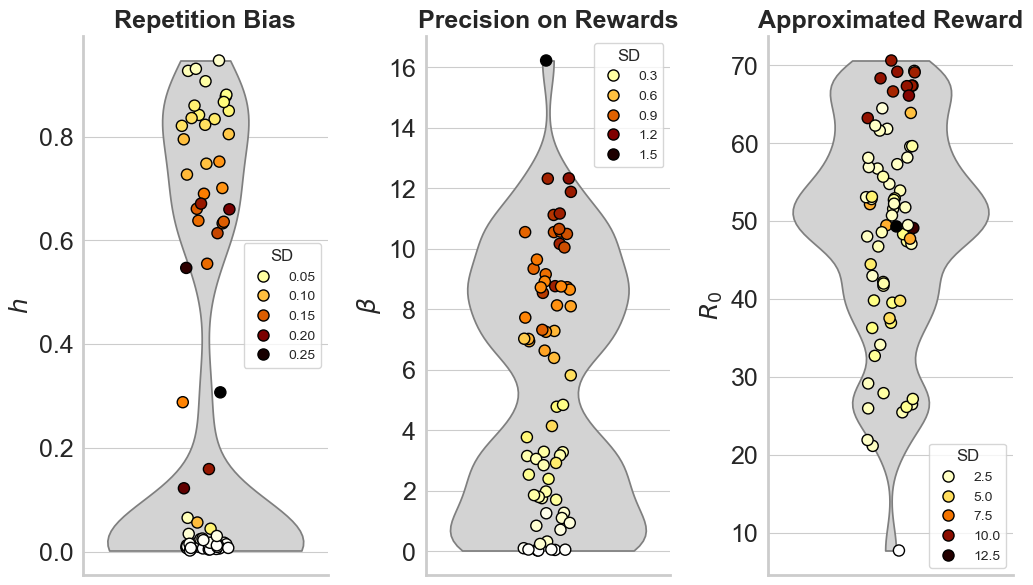

In [8]:
fig, axs = plt.subplots(1,3, figsize=(12,7), gridspec_kw={'wspace':.4})

yLabels = ('h', r'\beta', 'R_0')
xLabels = ('Repetition Bias', 'Precision on Rewards', 'Approximated Reward')
legendLocs =('center right', 'upper right', 'lower right')
graphAnnotations = ('A', 'B', 'C')
graphAnnotationsCoords = np.array([[-.41, -.29, -.2], [1.1, 18, 80]])

# fig.suptitle('Estimated Parameters: EVPRM', fontsize=18, fontweight='bold', y=.93)

for idx, p in enumerate(parameterNames):
    sns.violinplot(data=dfPosteriorMeans, y=f'{p}_mean',  inner=None, cut=0, color='lightgrey', ax=axs[idx], 
                   bw_adjust=.5) #, density_norm='count')
    sns.stripplot(data=dfPosteriorMeans, y=f'{p}_mean', hue=f'{p}_SD', size=8, ax=axs[idx], linewidth=1, 
                  edgecolor='black', palette='afmhot_r')
    
    axs[idx].set_ylabel(rf'${yLabels[idx]}$', fontsize=18)
    axs[idx].set_title(f'{xLabels[idx]}', fontsize=18, weight='bold')
    axs[idx].legend(title='SD', title_fontsize=12, fontsize=10, loc=legendLocs[idx])
    #axs[idx].text(graphAnnotationsCoords[0,idx], graphAnnotationsCoords[1,idx], 
    #              graphAnnotations[idx], fontsize=20, weight='bold')

sns.despine()
#plt.savefig('../figures/fitted_params_EVPRM.svg', format='svg')
plt.show()

### Correlations between parameters

In [8]:
# calculate the correlation coefficients
dfPosteriorMeans[['h_mean', 'beta_mean', 'R0_mean']].corr()

,h_mean,beta_mean,R0_mean
h_mean,1.000000,-0.753091,0.124890
beta_mean,-0.753091,1.000000,0.298448
R0_mean,0.124890,0.298448,1.000000


In [9]:
pg.corr(dfPosteriorMeans['h_mean'], dfPosteriorMeans['beta_mean'])

,n,r,CI95%,p-val,BF10,power
pearson,70,-0.753091,"[-0.84, -0.63]",5.473256e-14,1.551e+11,1.0


In [10]:
pg.corr(dfPosteriorMeans['h_mean'], dfPosteriorMeans['R0_mean'])

,n,r,CI95%,p-val,BF10,power
pearson,70,0.12489,"[-0.11, 0.35]",0.302949,0.251,0.178363


In [11]:
pg.corr(dfPosteriorMeans['R0_mean'], dfPosteriorMeans['beta_mean'])

,n,r,CI95%,p-val,BF10,power
pearson,70,0.298448,"[0.07, 0.5]",0.01209,3.261,0.717485


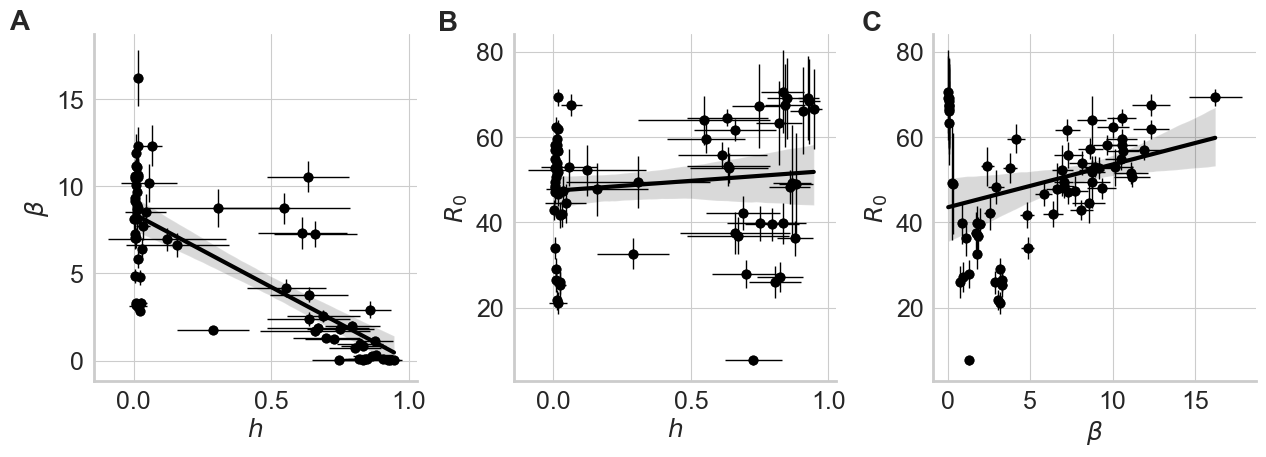

In [12]:
# plot correlations
onAxisX = ('h', 'h', 'beta')
onAxisY = ('beta', 'R0', 'R0')

xLabels = (r'$h$', r'$h$', r'$\beta$')
yLabels = (r'$\beta$', r'$R_0$', r'$R_0$')


graphAnnotations = ('A', 'B', 'C')
graphAnnotationsCoords = np.array([[-.45, -.42, -5.2], [19, 85, 85]])
# graphAnnotationsCoords = np.array([[-.23, -.23, -4], [17.7, 75, 75]]) for figure without errorbars

fig, axs = plt.subplots(1, len(onAxisX), figsize=(15,4.5), gridspec_kw={'wspace':.3})

for idx in range(len(onAxisX)):
    sns.regplot(data=dfPosteriorMeans, x=f'{onAxisX[idx]}_mean', y=f'{onAxisY[idx]}_mean', truncate=True, color='black', 
                scatter_kws={'s':40, 'color':'lightgrey', 'edgecolors':'black'}, ax=axs[idx])
    axs[idx].errorbar(data=dfPosteriorMeans, x=f'{onAxisX[idx]}_mean', y=f'{onAxisY[idx]}_mean', 
                      xerr=f'{onAxisX[idx]}_SD', yerr=f'{onAxisY[idx]}_SD', color='black', elinewidth=1, fmt='o')
    axs[idx].set_ylabel(yLabels[idx], fontsize=18)
    axs[idx].set_xlabel(xLabels[idx], fontsize=18)
    axs[idx].text(graphAnnotationsCoords[0,idx], graphAnnotationsCoords[1,idx], 
                  graphAnnotations[idx], fontsize=20, weight='bold')

sns.despine()
plt.show()

### Correlations

In [13]:
# add means to the inferred parameters
IdxDAS = 4
dfData['DAS'] = np.where(dfData['sequence_ID']==IdxDAS, 1, 0)
dfPosteriorMeans['pDAS'] = dfData['DAS'].groupby(dfData['Participant_ID']).mean().to_numpy()
dfPosteriorMeans['reward'] = dfData['reward'].groupby(dfData['Participant_ID']).mean().to_numpy()
dfPosteriorMeans['RT'] = dfData['RT'].groupby(dfData['Participant_ID']).mean().to_numpy()
dfPosteriorMeans['time_out'] = dfData['time_out'].groupby(dfData['Participant_ID']).sum().to_numpy()

In [14]:
# pDAS - R0
pg.corr(dfPosteriorMeans['R0_mean'], dfPosteriorMeans['pDAS'])

,n,r,CI95%,p-val,BF10,power
pearson,70,-0.177521,"[-0.4, 0.06]",0.141505,0.43,0.314929


In [15]:
# beta - reward
pg.corr(dfPosteriorMeans['beta_mean'], dfPosteriorMeans['reward'])

,n,r,CI95%,p-val,BF10,power
pearson,70,0.761251,"[0.64, 0.85]",2.023420e-14,4.037e+11,1.0


In [16]:
# habitual tendency - reward
pg.corr(dfPosteriorMeans['h_mean'], dfPosteriorMeans['reward'])

,n,r,CI95%,p-val,BF10,power
pearson,70,-0.694798,"[-0.8, -0.55]",2.522243e-11,4.317e+08,1.0


In [17]:
# habitual tendency - RT
pg.corr(dfPosteriorMeans['h_mean'], dfPosteriorMeans['RT'])

,n,r,CI95%,p-val,BF10,power
pearson,70,0.372807,"[0.15, 0.56]",0.001481,21.009,0.897286


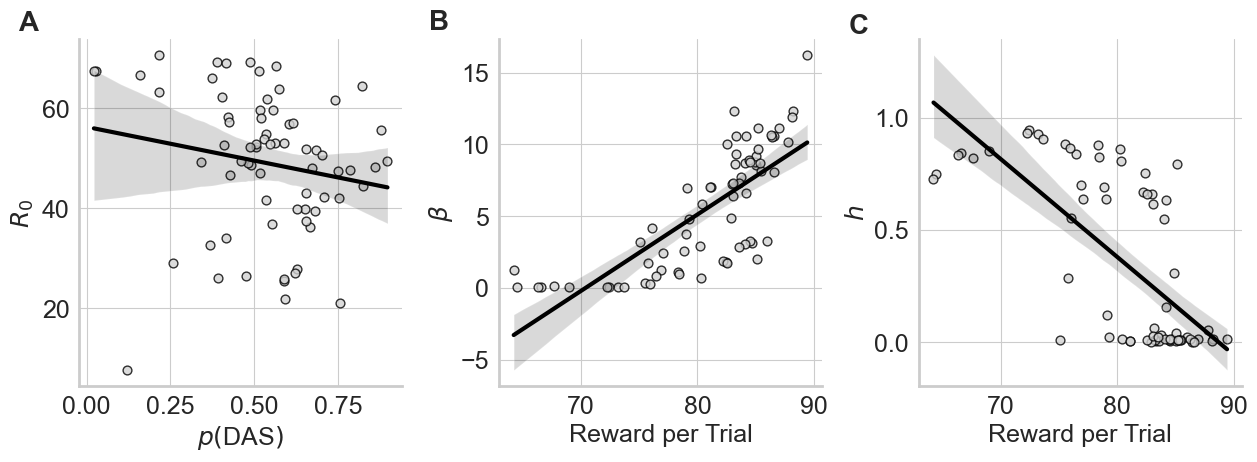

In [18]:
# plot correlations
onAxisX = ('pDAS', 'reward', 'reward')
onAxisY = ('R0_mean', 'beta_mean', 'h_mean')

xLabels = (r'$p($DAS$)$', 'Reward per Trial', 'Reward per Trial')
yLabels = (r'$R_0$', r'$\beta$', r'$h$')

graphAnnotations = ('A', 'B', 'C')
graphAnnotationsCoords = np.array([[-0.20, 57, 57], [75.5, 18, 1.375]])

fig, axs = plt.subplots(1, len(onAxisX), figsize=(15,4.5), gridspec_kw={'wspace':.3})

for idx in range(len(onAxisX)):
    sns.regplot(data=dfPosteriorMeans, x=onAxisX[idx], y=onAxisY[idx], truncate=True, color='black', 
                scatter_kws={'s':40, 'color':'lightgrey', 'edgecolors':'black'}, ax=axs[idx])
    axs[idx].set_ylabel(yLabels[idx], fontsize=18)
    axs[idx].set_xlabel(xLabels[idx], fontsize=18)
    axs[idx].text(graphAnnotationsCoords[0,idx], graphAnnotationsCoords[1,idx], 
                  graphAnnotations[idx], fontsize=20, weight='bold')

sns.despine()

plt.savefig('../figures/corr_DAS_h.svg', format='svg')

plt.show()

## PPC

In [20]:
# extract the predicted actions for all valid trials (1000 prediction for each observation)
PPC = az.extract(posteriorEVPRM, group='posterior_predictive', var_names=['Y'])[dfData.loc[dfData['time_out']==0].index]

# the observations
observations = dfData.loc[dfData['time_out']==0, 'sequence_ID']

# calculate the proportion of correct predictions for each observation (chance level=1/36=.027) and add it to the df
dfData['PPC_mean'] = np.nan
dfData.loc[dfData['time_out']==0, 'PPC_mean'] = (PPC.to_numpy()==observations.to_numpy()[:, np.newaxis]).mean(axis=1)

# add mean of each participant to the summary table df
dfPosteriorMeans['PPC'] = dfData['PPC_mean'].groupby(dfData['Participant_ID']).mean()

In [21]:
# get range
print(f'{dfPosteriorMeans["PPC"].min()} - {dfPosteriorMeans["PPC"].max()}')

0.04914435483870968 - 0.8628781249999999


In [22]:
# calculate correlations of PPC with parameter means and p(DAS)
print(f"PPC - h: {pg.corr(dfPosteriorMeans['PPC'], dfPosteriorMeans['h_mean'])}")
print(f"PPC - beta: {pg.corr(dfPosteriorMeans['PPC'], dfPosteriorMeans['beta_mean'])}")
print(f"PPC - R0: {pg.corr(dfPosteriorMeans['PPC'], dfPosteriorMeans['R0_mean'])}")
print(f"PPC - p(DAS): {pg.corr(dfPosteriorMeans['PPC'], dfPosteriorMeans['pDAS'])}")

PPC - h:           n         r          CI95%         p-val      BF10     power
pearson  70 -0.550303  [-0.7, -0.36]  8.010021e-07  2.25e+04  0.999144
PPC - beta:           n         r        CI95%         p-val       BF10  power
pearson  70  0.728328  [0.6, 0.82]  8.979377e-13  1.056e+10    1.0
PPC - R0:           n         r          CI95%     p-val   BF10     power
pearson  70 -0.123659  [-0.35, 0.11]  0.307777  0.248  0.175746
PPC - p(DAS):           n       r        CI95%         p-val       BF10  power
pearson  70  0.8441  [0.76, 0.9]  4.453198e-20  1.146e+17    1.0


#### look at PPC for each participant at plot correlations with free paramaters and p(DAS)

In [23]:
# calculte proportion of matched choices for each sequence
dfPPCSequences = dfData['PPC_mean'].groupby(dfData['sequence_ID']).mean().rename('PPC_mean').reset_index()

# calculate the proportion of how many times each sequence was used
dfPPCSequences['proportion'] = dfData['sequence_ID'].value_counts(normalize=True).reset_index().sort_values(by='sequence_ID')['proportion'].to_numpy()

# calculate PPC for all non DAS sequences
PPCnonDAS = dfData.loc[dfData['sequence_ID']!=IdxDAS, 'PPC_mean'].mean()
proportionNonDAS = 1-dfPPCSequences.loc[dfPPCSequences['sequence_ID']==IdxDAS, 'proportion'].to_numpy()[0]
dataNonDAS = {'sequence_ID':'non DAS', 'PPC_mean':PPCnonDAS, 'proportion':f'{proportionNonDAS:.1%}'}

# turn proportions to %
dfPPCSequences['proportion'] = dfPPCSequences['proportion'].apply(lambda x: f'{x:.1%}')
dfPPCSequences.sort_values(by='PPC_mean', inplace=True)

# add data for all non DAS sequences
dfPPCSequences.loc[len(dfPPCSequences)] = dataNonDAS

# change name of DAS
dfPPCSequences.loc[dfPPCSequences['sequence_ID']==IdxDAS, 'sequence_ID'] = 'DAS'

In [29]:
dfPPCSequences.iloc[-2:]

,sequence_ID,PPC_mean,proportion
4,DAS,0.749212,54.4%
36,non DAS,0.190754,45.6%


[]

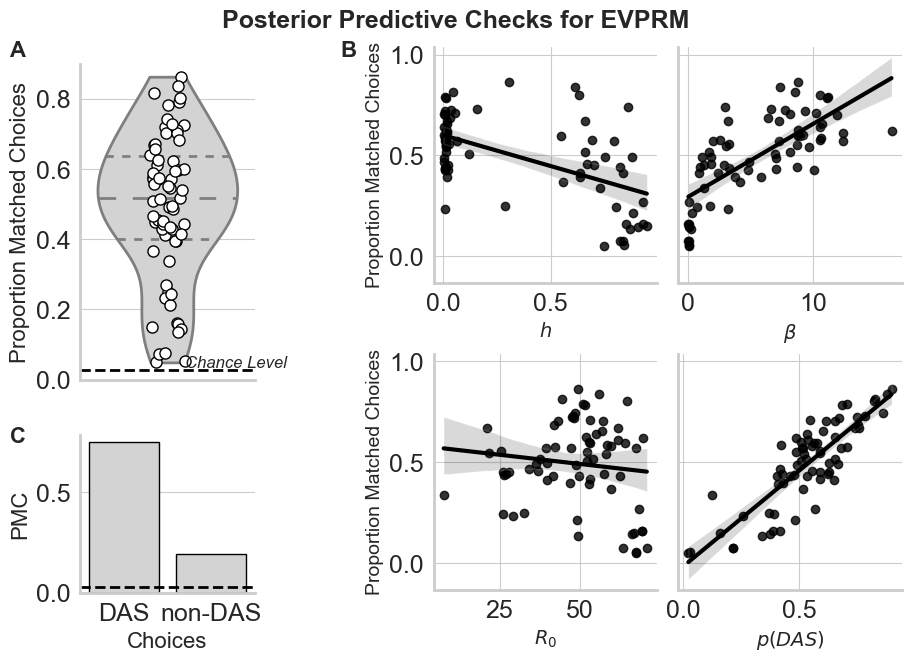

In [30]:
# plot PPC results
fig = plt.figure(figsize=(9,6.5), layout='constrained')
subFigs = fig.subfigures(1, 2, width_ratios=[1, 2], wspace=.1)
fig.suptitle('Posterior Predictive Checks for EVPRM', fontsize=18, fontweight='bold')

# A) left distribution plot
axLeft = subFigs[0].subplots(2, 1, gridspec_kw={'height_ratios': [2, 1], 'hspace':.1})

sns.violinplot(dfData['PPC_mean'].groupby(dfData['Participant_ID']).mean(), inner='quart', cut=0, color='lightgrey', ax=axLeft[0])
sns.stripplot(dfData['PPC_mean'].groupby(dfData['Participant_ID']).mean(), size=8, linewidth=1, color='white', edgecolor='black', ax=axLeft[0])
axLeft[0].axhline(y=1/36, color='black', linestyle='--')
axLeft[0].set_ylim((0,.9))
axLeft[0].set_ylabel('Proportion Matched Choices', fontsize=16)
axLeft[0].set_xticks([])

axLeft[0].text(-.9, .92, 'A', fontsize=16, weight='bold')
axLeft[0].text(.1, .035, 'Chance Level', fontsize=12, fontstyle='italic') 

# C) left bar plot
sns.barplot(data=dfPPCSequences.iloc[-2:], x='sequence_ID', y='PPC_mean', ax=axLeft[1], color='lightgrey', edgecolor='black')
axLeft[1].set_ylabel('PMC', fontsize=16)
axLeft[1].set_xlabel('Choices', fontsize=16)
axLeft[1].set_xticks(np.arange(2), ['DAS', 'non-DAS'])
axLeft[1].axhline(y=1/36, color='black', linestyle='--')
axLeft[1].text(-1.3, .75, 'C', fontsize=16, weight='bold')

# B) right 4x4 correlation plots
axRight = subFigs[1].subplots(2, 2, sharey=True)

axRight[0,0].text(-.48, .99, 'B', fontsize=16, weight='bold') 

sns.regplot(y=dfData['PPC_mean'].groupby(dfData['Participant_ID']).mean(), x=dfPosteriorMeans['h_mean'], color='black', ax=axRight[0,0])
axRight[0,0].set_xlabel(f'$h$', fontsize=14)
axRight[0,0].set_ylabel('')
axRight[0,0].set_ylabel('Proportion Matched Choices', fontsize=14)

sns.regplot(y=dfData['PPC_mean'].groupby(dfData['Participant_ID']).mean(), x=dfPosteriorMeans['beta_mean'], color='black', ax=axRight[0,1])
axRight[0,1].set_xlabel(r'$\beta$', fontsize=14)
axRight[0,1].set_ylabel('')

sns.regplot(y=dfData['PPC_mean'].groupby(dfData['Participant_ID']).mean(), x=dfPosteriorMeans['R0_mean'], color='black', ax=axRight[1,0])
axRight[1,0].set_xlabel(r'$R_0$', fontsize=14)
axRight[1,0].set_ylabel('Proportion Matched Choices', fontsize=14)

sns.regplot(y=dfData['PPC_mean'].groupby(dfData['Participant_ID']).mean(), x=dfPosteriorMeans['pDAS'], color='black', ax=axRight[1,1])
axRight[1,1].set_xlabel(r'$p(DAS)$', fontsize=14)
axRight[1,1].set_ylabel('')

#plt.tight_layout()
sns.despine()
plt.plot()

### Create table with correlations between inferred parameter values and performance measures

In [31]:
# calculate correlations
correlationMatrix = dfPosteriorMeans[['h_mean', 'beta_mean', 'R0_mean', 'pDAS', 'reward', 'RT', 'time_out']].corr(method='pearson')
#print(correlationMatrix.round(2).to_latex())
correlationMatrix

,h_mean,beta_mean,R0_mean,pDAS,reward,RT,time_out
h_mean,1.000000,-0.753091,0.124890,-0.218524,-0.694798,0.372807,0.321899
beta_mean,-0.753091,1.000000,0.298448,0.370966,0.761251,-0.443329,-0.272164
R0_mean,0.124890,0.298448,1.000000,-0.177521,-0.109330,0.253322,0.158459
pDAS,-0.218524,0.370966,-0.177521,1.000000,0.665553,-0.582681,-0.396706
reward,-0.694798,0.761251,-0.109330,0.665553,1.000000,-0.697127,-0.518514
RT,0.372807,-0.443329,0.253322,-0.582681,-0.697127,1.000000,0.649134
time_out,0.321899,-0.272164,0.158459,-0.396706,-0.518514,0.649134,1.000000


In [ ]:
# get the p-values
def pearson_pval(x, y):
    return stats.pearsonr(x,y)[1]

In [35]:
pValMatrix = dfPosteriorMeans[['h_mean', 'beta_mean', 'R0_mean', 'pDAS', 'reward', 'RT', 'time_out']].corr(method=pearson_pval)
pValMatrix.round(3)

,h_mean,beta_mean,R0_mean,pDAS,reward,RT,time_out
h_mean,1.000,0.000,0.303,0.069,0.000,0.001,0.007
beta_mean,0.000,1.000,0.012,0.002,0.000,0.000,0.023
R0_mean,0.303,0.012,1.000,0.142,0.368,0.034,0.190
pDAS,0.069,0.002,0.142,1.000,0.000,0.000,0.001
reward,0.000,0.000,0.368,0.000,1.000,0.000,0.000
RT,0.001,0.000,0.034,0.000,0.000,1.000,0.000
time_out,0.007,0.023,0.190,0.001,0.000,0.000,1.000


### Correlation between general h of EVPRM and non-DAS h of alternative EVPRM model
Correlation between the $h$ parameter of EVPRM that represents a general repetition bias over all sequences, and the $h$ parameter for all non-DAS sequences of an alternative EVPRM model, that has separate $h$ parameter for DAS and all non-DAS sequences.

In [14]:
posteriorEVPRMv2 = pd.read_pickle(f'{path}posterior_EVPRM_v2_empirical.pkl')

# create list with free parameter names
parameterNames = ('h', 'h_DAS', 'beta', 'R0')

# create the panda and feed it
dfPosteriorMeansV2 = pd.DataFrame()

for p in parameterNames:
    dfPosteriorMeansV2[f'{p}_mean'] = az.summary(posteriorEVPRMv2, var_names=[f'{p}'])['mean'].to_numpy()
    dfPosteriorMeansV2[f'{p}_SD'] = az.summary(posteriorEVPRMv2, var_names=[f'{p}'])['sd'].to_numpy()

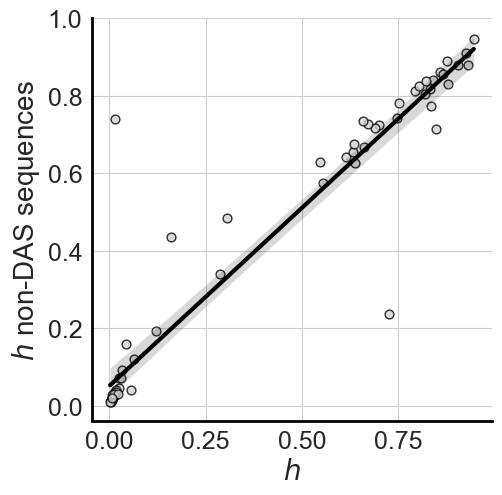

In [11]:
dfPlotData = pd.DataFrame()
dfPlotData['h_nonDAS'] = dfPosteriorMeansV2['h_mean']
dfPlotData['h'] = dfPosteriorMeans['h_mean']

#plt.figure(figsize=(10,6))
sns.lmplot(data=dfPlotData, x='h', y='h_nonDAS', 
           scatter_kws={'s':40, 'color':'lightgrey', 'edgecolors':'black'},
           line_kws={'color':'black'})
plt.ylabel('$h$ non-DAS sequences', fontsize=20)
plt.xlabel('$h$', fontsize=20)

ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')

sns.despine()
plt.savefig('../figures/corr_h_h_separate.svg', format='svg')
plt.show()

In [12]:
pg.corr(dfPlotData['h'], dfPlotData['h_nonDAS'])

,n,r,CI95%,p-val,BF10,power
pearson,70,0.951292,"[0.92, 0.97]",1.796391e-36,8.481e+32,1.0


In [2]:
# print date of last changes and version numbers
%load_ext watermark

%watermark -n -u -v -iv -w

Last updated: Fri Sep 27 2024

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.20.0

matplotlib: 3.8.4
sys       : 3.11.0 | packaged by conda-forge | (main, Jan 15 2023, 05:44:48) [Clang 14.0.6 ]
scipy     : 1.12.0
pandas    : 2.2.1
pingouin  : 0.5.4
seaborn   : 0.12.2
numpy     : 1.25.2
arviz     : 0.17.1

Watermark: 2.3.1

